<a href="https://colab.research.google.com/github/sleepypioneer/coffee-leaf-rust-predictor/blob/main/analysis/notebooks/leaf_rust_detection_exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Coffee Leaf Rust detection ☕🌿

[Hemileia vastatrix](https://en.wikipedia.org/wiki/Hemileia_vastatrix) a fungus which causes coffee leaf rust disease. This disease which reduces a plants ability to derive energy through photosynthesis, is extremely damaging to economics built on coffee cultivation as it can wipe out whole crops. The disease can be identified by the spores which cover the plants leaves.

In [1]:
from datetime import datetime
import pathlib
import random
import shutil
from typing import List
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img

%matplotlib inline

## Getting our Data 💾

In [2]:
! pip install -q kaggle

In order to use the Kaggle’s public API, you must first authenticate using an API token. From the site header, click on your user profile picture, then on “My Account” from the dropdown menu. This will take you to your account settings at https://www.kaggle.com/account. Scroll down to the section of the page labelled API:

To create a new token, click on the “Create New API Token” button. This will download a fresh authentication token onto your machine in the form of a `kaggle.json`

The cell below once run will require you to select this file for upload.

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sleepypioneer","key":"e53dd3e6f524d0e52f4b34ee3e73f65e"}'}

In [4]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
! kaggle datasets download -d 'badasstechie/coffee-leaf-diseases'

 88% 172M/196M [00:01<00:00, 108MB/s]
100% 196M/196M [00:01<00:00, 135MB/s]


In [7]:
! mkdir coffee-leaf-diseases


In [8]:
! unzip coffee-leaf-diseases.zip -d coffee-leaf-diseases &> /dev/null

In [9]:
# clean up downloaded zip
!rm -r coffee-leaf-diseases.zip

## Creating Train and Test data sets 🗂️

The first task is to split up our data so we have images for both our two classes: `rust` and `other` (disease that is not identified as rust).

In [10]:
train_data = pd.read_csv("coffee-leaf-diseases/train_classes.csv")

In [11]:
test_data = pd.read_csv("coffee-leaf-diseases/test_classes.csv")

In [12]:
train_data[train_data["rust"] == 1]

,id,miner,rust,phoma
44,44,1,1,0
45,45,1,1,0
46,46,1,1,0
47,47,1,1,0
48,48,1,1,0
...,...,...,...,...
1259,1595,0,1,0
1260,1596,0,1,0
1261,1597,0,1,0
1262,1598,0,1,0


We see here that images can be labelled both rust and miner. We kick out the images with double labels.

In [13]:
train_rust = train_data[(train_data["rust"] == 1) & (train_data["miner"] != 1) & (train_data["phoma"] != 1)]
train_rust_ids = train_rust["id"].to_list()

In [14]:
other_train_ids = train_data[(train_data["rust"] == 0)]["id"].to_list()

In [15]:
test_rust = test_data[(test_data["rust"] == 1) & (test_data["miner"] != 1) & (test_data["phoma"] != 1)]
test_rust_ids = test_rust["id"].to_list()

In [16]:
other_test_ids = test_data[(test_data["rust"] == 0)]["id"].to_list()

In [17]:
print(f"Number of train rust images: {len(train_rust_ids)}")
print(f"Number of test rust images: {len(test_rust_ids)}")

Number of train rust images: 260
Number of test rust images: 60


In [18]:
os.mkdir("coffee-leaf-diseases/coffee-leaf-diseases/train/images/rust")
os.mkdir("coffee-leaf-diseases/coffee-leaf-diseases/train/images/other")

os.mkdir("coffee-leaf-diseases/coffee-leaf-diseases/test/images/rust")
os.mkdir("coffee-leaf-diseases/coffee-leaf-diseases/test/images/other")

In [19]:
for n in train_rust_ids:
    shutil.move(f"./coffee-leaf-diseases/coffee-leaf-diseases/train/images/{n}.jpg", f"./coffee-leaf-diseases/coffee-leaf-diseases/train/images/rust/")

In [20]:
for n in test_rust_ids:
    shutil.move(f"./coffee-leaf-diseases/coffee-leaf-diseases/test/images/{n}.jpg", f"./coffee-leaf-diseases/coffee-leaf-diseases/test/images/rust/")

In [21]:
for n in other_train_ids:
    shutil.move(f"./coffee-leaf-diseases/coffee-leaf-diseases/train/images/{n}.jpg", f"./coffee-leaf-diseases/coffee-leaf-diseases/train/images/other/")

In [22]:
for n in other_test_ids:
    shutil.move(f"./coffee-leaf-diseases/coffee-leaf-diseases/test/images/{n}.jpg", f"./coffee-leaf-diseases/coffee-leaf-diseases/test/images/other/")

Let's take a look at the kind of image we have.

<PIL.Image.Image image mode=RGB size=299x299 at 0x7F4EF20FF650>


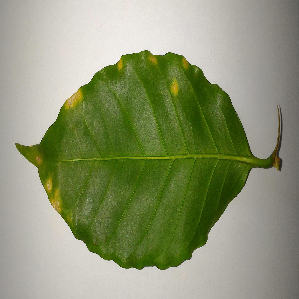

In [23]:
img_path = f"./coffee-leaf-diseases/coffee-leaf-diseases/train/images/rust/{train_rust_ids[0]}.jpg"
rust_leaf = load_img(img_path, target_size=(299, 299))
print(rust_leaf)
rust_leaf

<PIL.Image.Image image mode=RGB size=299x299 at 0x7F4EF20F0550>


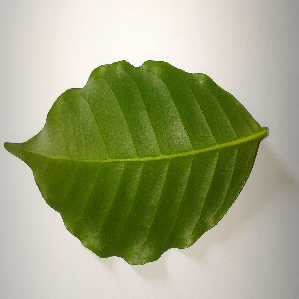

In [24]:
img_path = f"./coffee-leaf-diseases/coffee-leaf-diseases/train/images/other/{other_train_ids[0]}.jpg"
non_rust_leaf = load_img(img_path, target_size=(299, 299))
print(non_rust_leaf)
non_rust_leaf

When creating our data sets we did have images that were marked rust but also a different disease, we want to ignore these multip diseased images so we will remove them from all three datasets.

In [25]:
!cd coffee-leaf-diseases/coffee-leaf-diseases/test/images && find -type f -not -path '*/other*' -not -path '*/rust*' -delete

In [26]:
!cd coffee-leaf-diseases/coffee-leaf-diseases/train/images && find -type f -not -path '*/other*' -not -path '*/rust*' -delete

## Training our model ⚙️

In [27]:
train_data_path = "./coffee-leaf-diseases/coffee-leaf-diseases/train/images/"

In [28]:
batch_size = 32
img_height = 150
img_width = 150
input_shape=(150, 150, 3)
data_dir = pathlib.Path(train_data_path)

In [29]:
# allows us to read images from storage and use them for training
train_gen = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.2)

train_ds = train_gen.flow_from_directory(
    data_dir,
    subset="training",
    target_size=(img_height, img_width),
    batch_size=batch_size
)

Found 973 images belonging to 2 classes.


In [30]:
# view the classes we have available in our training data
train_ds.class_indices

{'other': 0, 'rust': 1}

In [31]:
val_ds = train_gen.flow_from_directory(
    data_dir,
    subset="validation",
    target_size=(img_height, img_width),
    batch_size=batch_size
)

Found 243 images belonging to 2 classes.


In [32]:
val_ds.class_indices

{'other': 0, 'rust': 1}

In [33]:
def make_model(input_size=150, learning_rate=0.01, size_inner=100,
               droprate=0.5):

    base_model = Xception(
        weights='imagenet',
        include_top=False,
        input_shape=(input_size, input_size, 3)
    )

    base_model.trainable = False

    #########################################

    inputs = keras.Input(shape=(input_size, input_size, 3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    
    inner = keras.layers.Dense(size_inner, activation='relu')(vectors)
    drop = keras.layers.Dropout(droprate)(inner)
    
    outputs = keras.layers.Dense(2)(drop)
    
    model = keras.Model(inputs, outputs)
    
    #########################################

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )
    
    return model

In [34]:
checkpoint = keras.callbacks.ModelCheckpoint(
    'xception_v4_1_{epoch:02d}_{val_accuracy:.3f}.h5',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)

### Tuning the learning rate 🔧
Learning rate parameter is the most important thing to tune.
- how fast a model learns
- FAST: High learning rate - consume a lot of learning material quickly but not thorough
- SLOW: Low learning rate - focus on less material but learn it much more thorough
- if we use a high learning rate it could be we perform poorly (overfit) on validation where as a low learning rate may underfit so we have to find the right balance
- we try different parameters to see which gives us the best result

In [35]:
%%time

scores = {}

for lr in [0.0001, 0.001, 0.01, 0.1]:
    print(lr)

    model = make_model(learning_rate=lr)
    history = model.fit(train_ds, epochs=10, validation_data=val_ds, callbacks=[checkpoint])
    scores[lr] = history.history

    print()
    print()

0.0001
83697664/83683744 [==============================] - 1s 0us/step
Epoch 1/10
31/31 [==============================] - ETA: 0s - loss: 0.6263 - accuracy: 0.7050

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


31/31 [==============================] - 42s 972ms/step - loss: 0.6263 - accuracy: 0.7050 - val_loss: 0.4740 - val_accuracy: 0.7984
Epoch 2/10
31/31 [==============================] - 28s 901ms/step - loss: 0.4673 - accuracy: 0.7945 - val_loss: 0.4307 - val_accuracy: 0.8148
Epoch 3/10
31/31 [==============================] - 28s 900ms/step - loss: 0.4157 - accuracy: 0.8140 - val_loss: 0.4014 - val_accuracy: 0.8477
Epoch 4/10
31/31 [==============================] - 28s 902ms/step - loss: 0.3569 - accuracy: 0.8530 - val_loss: 0.3747 - val_accuracy: 0.8601
Epoch 5/10
31/31 [==============================] - 28s 899ms/step - loss: 0.3300 - accuracy: 0.8541 - val_loss: 0.3534 - val_accuracy: 0.8601
Epoch 6/10
31/31 [==============================] - 28s 890ms/step - loss: 0.3139 - accuracy: 0.8674 - val_loss: 0.3411 - val_accuracy: 0.8642
Epoch 7/10
31/31 [==============================] - 28s 894ms/step - loss: 0.2925 - accuracy: 0.8828 - val_loss: 0.3505 - val_accuracy: 0.8436
Epoch 8/10

CPU times: user 21.1 ms, sys: 992 µs, total: 22.1 ms
Wall time: 24.1 ms


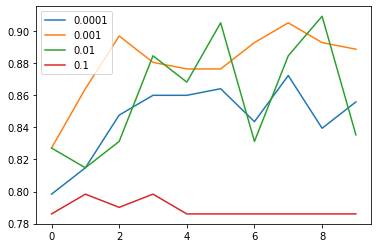

In [37]:
%%time

for lr in [0.0001, 0.001, 0.01, 0.1]:
  hist = scores[lr]
  plt.plot(hist['val_accuracy'], label=lr)


plt.legend()

In [38]:
learning_rate = 0.001

Adding more layers

In [39]:
%%time

scores = {}

for size in [10, 100, 1000]:
    print(size)

    model = make_model(learning_rate=learning_rate, size_inner=size)
    history = model.fit(train_ds, epochs=10, validation_data=val_ds)
    scores[size] = history.history

    print()
    print()

10
Epoch 1/4
31/31 [==============================] - 32s 944ms/step - loss: 0.4753 - accuracy: 0.7801 - val_loss: 0.3934 - val_accuracy: 0.8313
Epoch 2/4
31/31 [==============================] - 28s 897ms/step - loss: 0.3669 - accuracy: 0.8325 - val_loss: 0.3348 - val_accuracy: 0.8807
Epoch 3/4
31/31 [==============================] - 28s 899ms/step - loss: 0.3183 - accuracy: 0.8551 - val_loss: 0.3111 - val_accuracy: 0.9053
Epoch 4/4
31/31 [==============================] - 27s 885ms/step - loss: 0.2814 - accuracy: 0.8592 - val_loss: 0.3194 - val_accuracy: 0.8601


100
Epoch 1/4
31/31 [==============================] - 32s 957ms/step - loss: 0.4959 - accuracy: 0.7914 - val_loss: 0.3922 - val_accuracy: 0.8272
Epoch 2/4
31/31 [==============================] - 28s 901ms/step - loss: 0.3097 - accuracy: 0.8613 - val_loss: 0.2839 - val_accuracy: 0.8889
Epoch 3/4
31/31 [==============================] - 28s 915ms/step - loss: 0.2284 - accuracy: 0.9168 - val_loss: 0.2455 - val_accuracy: 0.93

CPU times: user 18.8 ms, sys: 0 ns, total: 18.8 ms
Wall time: 20.3 ms


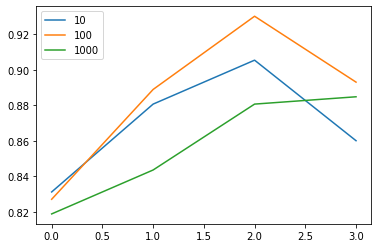

In [40]:
%%time

for size in [10, 100, 1000]:
  hist = scores[size]
  plt.plot(hist['val_accuracy'], label=size)

plt.legend()

In [41]:
size = 100

### Regularisation and dropout

In [42]:
scores = {}

for droprate in [0.0, 0.2, 0.5, 0.8]:
    print(droprate)

    model = make_model(
        learning_rate=learning_rate,
        size_inner=size,
        droprate=droprate
    )

    history = model.fit(train_ds, epochs=10, validation_data=val_ds)
    scores[droprate] = history.history

    print()
    print()

0.0
Epoch 1/10
31/31 [==============================] - 32s 956ms/step - loss: 0.4399 - accuracy: 0.7986 - val_loss: 0.3556 - val_accuracy: 0.8354
Epoch 2/10
31/31 [==============================] - 28s 897ms/step - loss: 0.2251 - accuracy: 0.9157 - val_loss: 0.3662 - val_accuracy: 0.8313
Epoch 3/10
31/31 [==============================] - 27s 878ms/step - loss: 0.1656 - accuracy: 0.9394 - val_loss: 0.2524 - val_accuracy: 0.8765
Epoch 4/10
31/31 [==============================] - 27s 887ms/step - loss: 0.1343 - accuracy: 0.9538 - val_loss: 0.2510 - val_accuracy: 0.8848
Epoch 5/10
31/31 [==============================] - 28s 897ms/step - loss: 0.1034 - accuracy: 0.9692 - val_loss: 0.3026 - val_accuracy: 0.8765
Epoch 6/10
31/31 [==============================] - 28s 893ms/step - loss: 0.0985 - accuracy: 0.9609 - val_loss: 0.2850 - val_accuracy: 0.8848
Epoch 7/10
31/31 [==============================] - 27s 904ms/step - loss: 0.0707 - accuracy: 0.9815 - val_loss: 0.3629 - val_accuracy: 0.

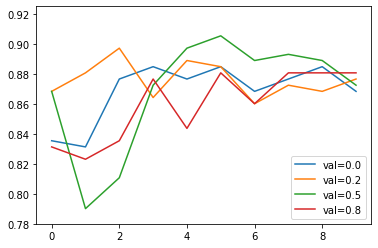

In [45]:
for droprate, hist in scores.items():
    plt.plot(hist['val_accuracy'], label=('val=%s' % droprate))

plt.ylim(0.78, 0.925)
plt.legend()

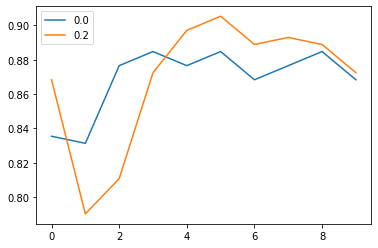

In [47]:
hist = scores[0.0]
plt.plot(hist['val_accuracy'], label=0.0)

hist = scores[0.5]
plt.plot(hist['val_accuracy'], label=0.2)

plt.legend()

In [49]:
droprate = 0.2

### Data Augmentation


## Training a larger model

In [50]:
input_size = 299

In [51]:
train_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    # shear_range=10,
    zoom_range=0.1,
    horizontal_flip=True,
    validation_split=0.2
)

train_ds = train_gen.flow_from_directory(
    data_dir,
    subset="training",
    target_size=(input_size, input_size),
    batch_size=32
)

val_ds = train_gen.flow_from_directory(
    data_dir,
    subset="validation",
    target_size=(input_size, input_size),
    batch_size=32,
    shuffle=False
)

Found 973 images belonging to 2 classes.
Found 243 images belonging to 2 classes.


## Traing the final model

In [54]:
print(f"""Final parameters: \n
    input_size={input_size}, \n
    learning_rate={learning_rate}, \n
    size_inner={size}, \n
    droprate={droprate} \n
""")

Final parameters: 

    input_size=299, 

    learning_rate=0.001, 

    size_inner=100, 

    droprate=0.2 




In [55]:
final_model = make_model(
    input_size=input_size,
    learning_rate=learning_rate,
    size_inner=size,
    droprate=droprate
)

history = model.fit(train_ds, epochs=10, validation_data=val_ds,
                   callbacks=[checkpoint])

Epoch 1/10
31/31 [==============================] - 52s 2s/step - loss: 0.2736 - accuracy: 0.8798 - val_loss: 0.2490 - val_accuracy: 0.9095
Epoch 2/10
31/31 [==============================] - ETA: 0s - loss: 0.2274 - accuracy: 0.9044

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


31/31 [==============================] - 49s 2s/step - loss: 0.2274 - accuracy: 0.9044 - val_loss: 0.2295 - val_accuracy: 0.9177
Epoch 3/10
31/31 [==============================] - 49s 2s/step - loss: 0.2028 - accuracy: 0.9209 - val_loss: 0.2059 - val_accuracy: 0.9259
Epoch 4/10
31/31 [==============================] - 49s 2s/step - loss: 0.1711 - accuracy: 0.9291 - val_loss: 0.1990 - val_accuracy: 0.9342
Epoch 5/10
31/31 [==============================] - 49s 2s/step - loss: 0.1740 - accuracy: 0.9311 - val_loss: 0.1866 - val_accuracy: 0.9300
Epoch 6/10
31/31 [==============================] - 49s 2s/step - loss: 0.1644 - accuracy: 0.9332 - val_loss: 0.1898 - val_accuracy: 0.9259
Epoch 7/10
31/31 [==============================] - 48s 2s/step - loss: 0.1465 - accuracy: 0.9466 - val_loss: 0.1669 - val_accuracy: 0.9300
Epoch 8/10
31/31 [==============================] - 49s 2s/step - loss: 0.1388 - accuracy: 0.9414 - val_loss: 0.1672 - val_accuracy: 0.9424
Epoch 9/10
31/31 [=============

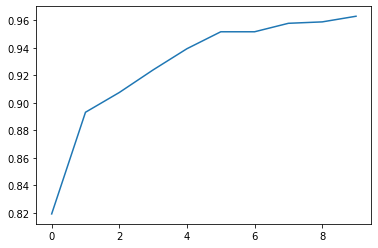

In [56]:
plt.plot(hist['accuracy'])

In [57]:
final_model.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_24 (InputLayer)       [(None, 299, 299, 3)]     0         
                                                                 
 xception (Functional)       (None, 10, 10, 2048)      20861480  
                                                                 
 global_average_pooling2d_11  (None, 2048)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_22 (Dense)            (None, 100)               204900    
                                                                 
 dropout_11 (Dropout)        (None, 100)               0         
                                                                 
 dense_23 (Dense)            (None, 2)                 202       
                                                          

In [58]:
version = "1"
timestamp = datetime.utcnow().strftime("%Y-%m-%d_%H:%M")
model_name = f"xception_v{version}_{timestamp}.h5"

In [59]:
final_model.save(model_name)
print(f"Latest saved model: {model_name}")

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Latest saved model: xception_v1_2022-01-16_16:30.h5


In [60]:
files.download(model_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Using our model

In [61]:
model = keras.models.load_model(model_name)

In [62]:
test_data_path = "./coffee-leaf-diseases/coffee-leaf-diseases/test/images/"
batch_size = 32
img_height = 150
img_width = 150
input_shape=(150, 150, 3)
test_data_dir = pathlib.Path(test_data_path)

In [63]:
test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_ds = test_gen.flow_from_directory(
    test_data_dir,
    target_size=(img_height, img_width),
    batch_size=32,
    shuffle=False
)

Found 388 images belonging to 2 classes.


In [64]:
final_model.evaluate(test_ds)

13/13 [==============================] - 10s 716ms/step - loss: 0.9904 - accuracy: 0.1804


[0.9903637766838074, 0.18041236698627472]

In [65]:
classes = list(test_ds.class_indices.keys())
classes

['other', 'rust']

<PIL.Image.Image image mode=RGB size=299x299 at 0x7F4EF2097890>


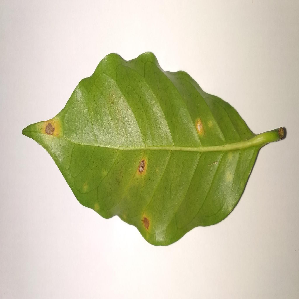

In [68]:
random_idx = random.randint(0, len(test_rust_ids))
img_path = f"./coffee-leaf-diseases/coffee-leaf-diseases/test/images/rust/{test_rust_ids[random_idx]}.jpg"
example_rust_leaf = load_img(img_path, target_size=(input_size, input_size))
print(example_rust_leaf)
example_rust_leaf

In [69]:
x = np.array(example_rust_leaf)
X = np.array([x])
X = preprocess_input(X)

pred = final_model.predict(X)

dict(zip(classes, pred[0]))

{'other': 0.14200833, 'rust': 0.17925766}

<PIL.Image.Image image mode=RGB size=299x299 at 0x7F4E36F43990>


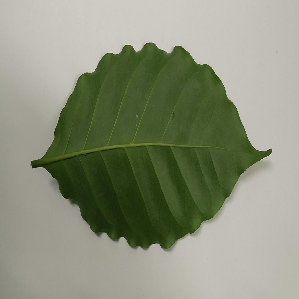

In [70]:
random_idx = random.randint(0, len(other_test_ids))
img_path = f"./coffee-leaf-diseases/coffee-leaf-diseases/test/images/other/{other_test_ids[random_idx]}.jpg"
example_other_leaf = load_img(img_path, target_size=(input_size, input_size))
print(example_other_leaf)
example_other_leaf

In [71]:
x = np.array(example_other_leaf)
X = np.array([x])
X = preprocess_input(X)

pred = final_model.predict(X)

dict(zip(classes, pred[0]))

{'other': -0.2624343, 'rust': 0.33117354}